This notebook is by Anastasia Ruzmaikina.

In this notebook we use the PyTorch multi-layer neural network as a Classifier to classify a wine as 'high quality' or 'low quality' based on eleven attributes such as density, sulfates, alhohol, fixed acidity etc. We use a data set of 6496 wines.

The PyTorch Neural Network Classifier is very accurate. After fine tuning the hyperparameters, we can predict if the wine is high quality with accuracy 80.5%.

In this notebook, the author used the methods learned in the course on PyTorch at the Machine Learning University on machinelearningplus.com

To begin with, we load all the necessary PyTorch libraries.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from torch.autograd import Variable

Next we load useful Python libraries.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

Then we load sklearn metrics we may need.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, r2_score

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container ( width:100% !important; )</style>"))

In [5]:
!mkdir Checkpoint  #directory for checkpoints

mkdir: Checkpoint: File exists


First we load the data and understand the data.



In [6]:
data = pd.read_csv("wine1.csv")
data

,Unnamed: 0.1,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color,high_quality
0,0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red,0
1,1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red,0
2,2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red,0
3,3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red,1
4,4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6492,4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white,1
6493,6493,4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white,0
6494,6494,4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white,1
6495,6495,4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white,1


The columns 'Unnamed: 0.1' and 'Unnamed: 0' carry no new information, so we drop them. 

The column 'quality' determines the column 'high_quality' (if quality of wine is 6 or more, it is considered high quality), so we drop the column 'quality'.

We drop the column 'color'.

In [7]:
#drop unnecessary columns
data.drop(['Unnamed: 0.1'], axis=1, inplace = True)
data.drop(['Unnamed: 0'], axis = 1, inplace = True)
data.drop(['quality'], axis = 1, inplace = True)
data.drop(['color'], axis = 1, inplace = True)
print("The columns are: ")
print(data.columns)
data.head()

The columns are: 
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'high_quality'],
      dtype='object')


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,high_quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


We can look at the column statistics.

In [8]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,high_quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,0.633061
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.482007
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000


To check the distribution of variables, we plot histograms of variables to find if they are normal or skewed.



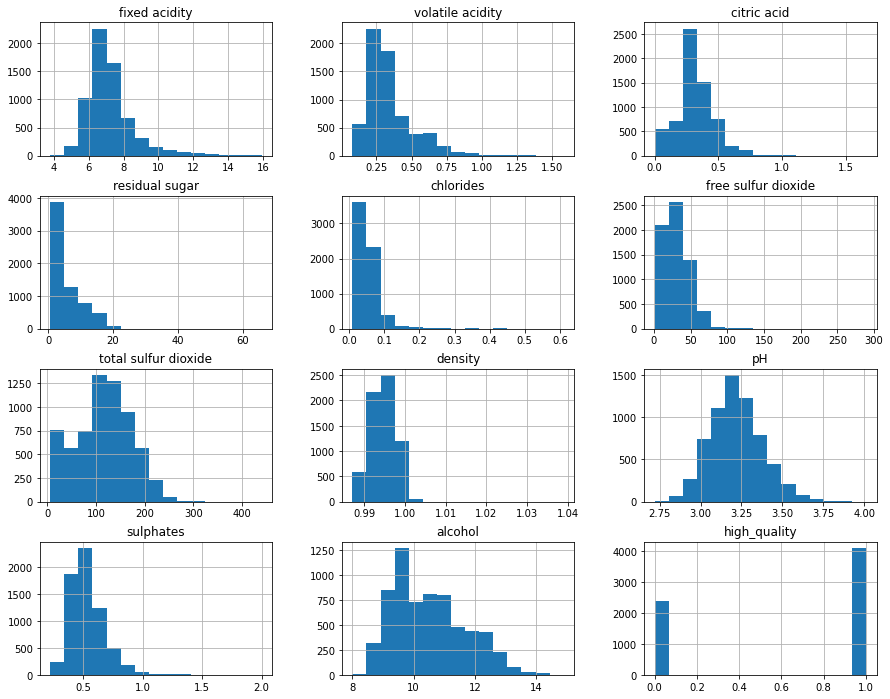

In [9]:
# plot histograms of the variables
params = data

params.hist(figsize=(15,12),bins = 15)

plt.show()

We can see that the columns 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide' are right-skewed and all the other columns have more symmetric distributions.



We first divide the data into a training set and the test set. We shall consider the rows 0 to 5999 as a training set, and rows 6000 to 6496 as a test set.

The X data are the first 11 columns. The y data is the last column 'high_quality'. We reshape the data as a PyTorch Tensor.

In [10]:
#training X data
X_data = Variable(torch.Tensor(np.array(data.iloc[:6000,:11]).reshape(6000,11)))
X_data

tensor([[7.4000, 0.7000, 0.0000,  ..., 3.5100, 0.5600, 9.4000],
        [7.8000, 0.8800, 0.0000,  ..., 3.2000, 0.6800, 9.8000],
        [7.8000, 0.7600, 0.0400,  ..., 3.2600, 0.6500, 9.8000],
        ...,
        [7.4000, 0.2700, 0.2600,  ..., 3.1100, 0.6000, 9.8000],
        [6.6000, 0.2400, 0.2200,  ..., 3.1000, 0.6700, 9.4000],
        [7.4000, 0.2700, 0.2600,  ..., 3.1100, 0.6000, 9.8000]])

In [11]:
#training y data
y_data = Variable(torch.Tensor(np.array(data.iloc[:6000,11:12]).reshape(6000,1)))
y_data[0:50]

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

We start with a simple one layer neural network. It has eleven inputs (eleven X columns), and one output (y column).

In [9]:
class LinearClassification(nn.Module):
    def __init__(self):
        super(LinearClassification, self).__init__()
        self.linear = nn.Linear(11,1)
    def forward(self, x):
        predict_y = self.linear(x)
        return predict_y

We take the loss funtion to be the Binary Cross Entropy Loss function, which we try to minimize.

We use Stochastic Gradient Descent to update the weights. We take a learning rate to be 0.00001, because this model does not converge for higher learning rates.

In [10]:
model = LinearClassification()
criterion = nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.00001)

/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


We need to set the number of iterations (epochs) to be large, here it is 500000, because the loss function (i.e cost function) decreases very slowly.

In [11]:
list = []
for epoch in range(500000):
    predict_y = torch.sigmoid(model(X_data))
    loss = criterion(predict_y, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    list.append(loss.item())
    if (epoch % 10000 == 0):
        print('epoch {}, cost function {}'.format(epoch, loss.item()))

epoch 0, cost function 31.25153350830078
epoch 10000, cost function 0.6406340599060059
epoch 20000, cost function 0.6252461671829224
epoch 30000, cost function 0.621947169303894
epoch 40000, cost function 0.6200258135795593
epoch 50000, cost function 0.618710994720459
epoch 60000, cost function 0.617693305015564
epoch 70000, cost function 0.6168316006660461
epoch 80000, cost function 0.6160631775856018
epoch 90000, cost function 0.6153541803359985
epoch 100000, cost function 0.6146884560585022
epoch 110000, cost function 0.614057719707489
epoch 120000, cost function 0.6134560108184814
epoch 130000, cost function 0.6128807067871094
epoch 140000, cost function 0.6123297214508057
epoch 150000, cost function 0.6118001937866211
epoch 160000, cost function 0.6112909317016602
epoch 170000, cost function 0.610803484916687
epoch 180000, cost function 0.6103386282920837
epoch 190000, cost function 0.6098864078521729
epoch 200000, cost function 0.6094481348991394
epoch 210000, cost function 0.609

Here we graph the cost function as a function of number of iterations.

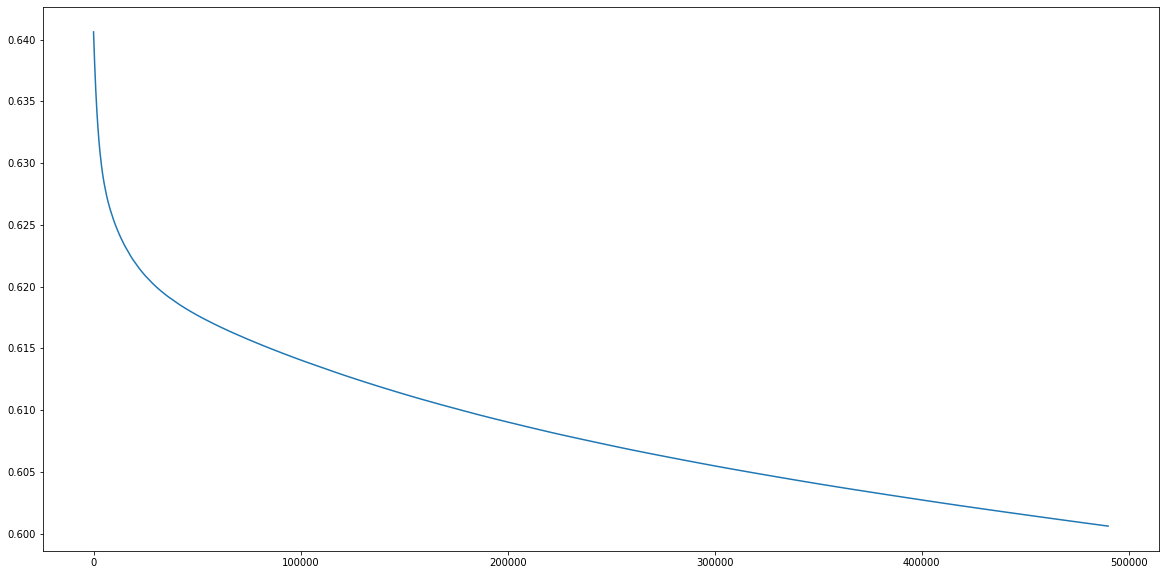

In [14]:
plt.figure(figsize = (20,10))
plt.plot(list[10000:])

We use the final model to make predictions of the y data using the training set of X data. Then we interpret each predicted y as 0 if y < 0.5, and as 1 otherwise. We store the predicted values of y in the numpy array train_y.

In [15]:
#translate predictions on training data into 0s and 1s
train_y = torch.sigmoid(model(X_data)).flatten().detach().numpy()
y_train = [0]*len(train_y)
for i in range(len(train_y)):
    if train_y[i] < 0.5:
        y_train[i] = 0
    else:
        y_train[i] = 1
train_y = np.array(y_train)
print(train_y)

[1 1 1 ... 1 1 1]


We now use the final model to make predictions of the y data using the test set of X data. Then we interpret each predicted y as 0 if y < 0.5, and as 1 otherwise. We store the predicted values of y in the numpy array pred_y.

We can graph both the actual values of y from the test set and the predicted values of y on the same graph.

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

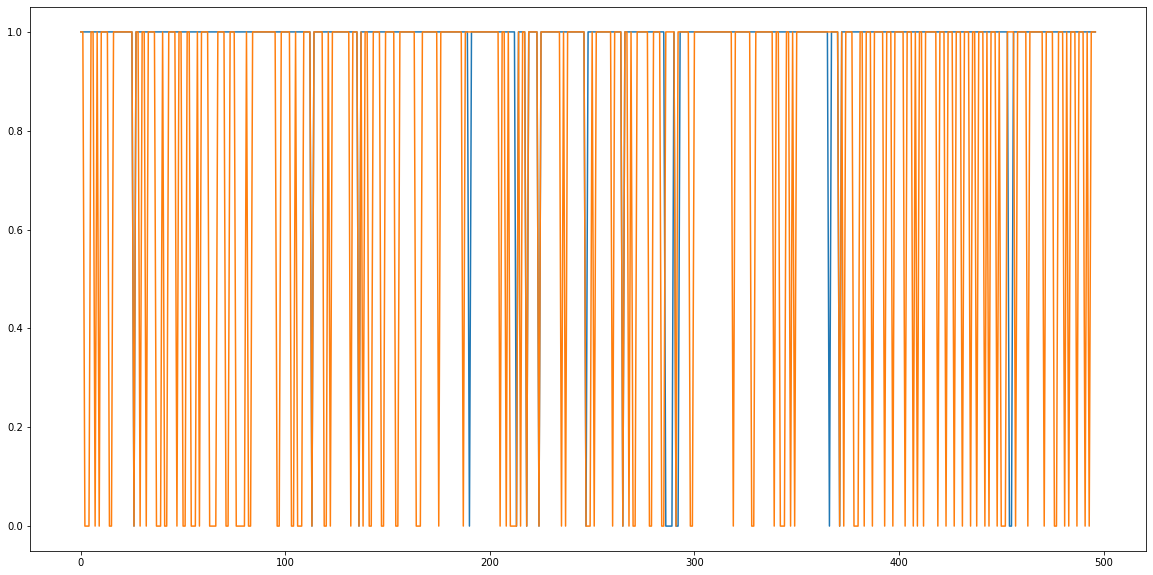

In [16]:
#translate predictions on test data into 0s and 1s
X_test = Variable(torch.Tensor(np.array(data.iloc[6000:,:11]).reshape(497,11)))
pred_y = torch.sigmoid(model(X_test)).flatten().detach().numpy()
y_pred = [0]*len(pred_y)
for i in range(len(pred_y)):
    if pred_y[i] < 0.5:
        y_pred[i] = 0
    else:
        y_pred[i] = 1
pred_y = np.array(y_pred)
print(pred_y)
plt.figure(figsize=(20,10))
plt.plot(pred_y)
plt.plot(np.array(data.iloc[6000:,11]))


We can calculate certain metrics to measure accuracy of our prediction.

First metric is the root mean square error, RMSE, which measures the difference between predicted values and actual values. Here we give both the RMSE for the training set and RMSE for the test set.

In [19]:
print("train RMSE {}".format(np.sqrt(np.mean((train_y-np.array(data.iloc[:6000,11]))**2))))
print("test RMSE {}".format(np.sqrt(np.mean((pred_y-np.array(data.iloc[6000:,11]))**2))))

train RMSE 0.5955389715767279
test RMSE 0.511438575489759


Next we give the confusion matrix for the training set and the test set. 

The confusion matrix entries are: 

true negative, false positive

false negative, true positive.

In [22]:
print(confusion_matrix(np.array(data.iloc[:6000,11]), np.array(train_y)))
print(confusion_matrix(np.array(data.iloc[6000:,11]), pred_y))

[[ 539 1714]
 [ 414 3333]]
[[ 10 121]
 [  9 357]]


Next we give the accuracy of prediction for both the training data and the test data. 

The accuracy of prediction is the number of correct predictions divided by the total number of data points, multiplied by 100%.

In [21]:
print('train accuracy {} %'.format(100 - np.mean(np.abs(train_y-np.array(data.iloc[:6000,11]))*100)))
print('test accuracy {} %'.format(100 - np.mean(np.abs(pred_y-np.array(data.iloc[6000:,11]))*100)))


train accuracy 64.53333333333333 %
test accuracy 73.8430583501006 %


As we see, the accuracy we achieved after 500000 iterations is 74%. To do better, we can try a multi-layer Neural Netweork instead of one layer Neural Network.

In PyTorch, we can choose the device to use. Here only 'cpu' is available.

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Six Layer Neural Network:

In order to improve accuracy we are going to consider a multi-layer neural network consisting of six fully connected layers. The first layer nn.Linear(num_features, hidden_size) takes eleven features as an input (since there are eleven columns in X data). It has an output dimension with the number of features given by hidden_size. In between the layers we use the ReLU activation function (rectified linear unit) to introduce the non-linearity. Then we connect to another hidden layer which has an input dimension equal to hidden_size and an output dimension equal to hidden_size, use a ReLU activation function, etc. For simplicity we keep all of the hidden layers the same size. The size of the hidden layers is very important, larger hidden_size prevents overfitting (in my experience), but also makes the Neural Network much slower.

In [12]:
class SixLayerNeuralNet(nn.Module):  #fully connected neural network with hidden layers
    def __init__(self, num_features, hidden_size, num_classes):
        super(SixLayerNeuralNet, self).__init__()
        self.fc1 = nn.Linear(num_features, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = self.relu(out)
        out = self.fc6(out)
        out = self.relu(out)
        out = self.fc2(out)    
        return out 


The first layer has eleven features as an input, since input data has eleven columns, and 64 features as an output. The last layer has 64 features as an input and one feature as an output, since output data (y data) has one column. The hidden layers all have 64 features as an input and 64 features as an output.

In [13]:
num_features = 11
hidden_size = 64
num_classes = 1

We use Binary Cross Entropy Loss function to find the minimum, and Stochastic Gradient Descent method to optimize the weights. Here we can take a larger learning rate equal to 0.01, which gives a faster convergence.

In [14]:
model = SixLayerNeuralNet(11, 64, 1)
criterion = nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
print(model)

SixLayerNeuralNet(
  (fc1): Linear(in_features=11, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


We iterate the model for 500000 epochs.

In [22]:
list = []
for epoch in range(500000):
    loss_epoch = 0
    predict_y = torch.sigmoid(model(X_data))
    loss = criterion(predict_y, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_epoch += loss.item()
    list.append(loss.item())
    if (epoch % 5000 == 0):
        print('epoch {}, cost function {}'.format(epoch, loss.item()))

epoch 0, cost function 0.6806756854057312
epoch 5000, cost function 0.6446384191513062
epoch 10000, cost function 0.6281097531318665
epoch 15000, cost function 0.6110793948173523
epoch 20000, cost function 0.5856730341911316
epoch 25000, cost function 0.5854778289794922
epoch 30000, cost function 0.5792803168296814
epoch 35000, cost function 0.5698770880699158
epoch 40000, cost function 0.5623497366905212
epoch 45000, cost function 0.569423258304596
epoch 50000, cost function 0.5693557262420654
epoch 55000, cost function 0.5742126703262329
epoch 60000, cost function 0.5549654364585876
epoch 65000, cost function 0.5455165505409241
epoch 70000, cost function 0.5437443256378174
epoch 75000, cost function 0.5413640141487122
epoch 80000, cost function 0.5442326664924622
epoch 85000, cost function 0.5357356667518616
epoch 90000, cost function 0.531721293926239
epoch 95000, cost function 0.5333242416381836
epoch 100000, cost function 0.52591472864151
epoch 105000, cost function 0.520887136459

We graph the cost function as a function of the number of iterations. Notice that the convergence gets slower after 300000 iterations.

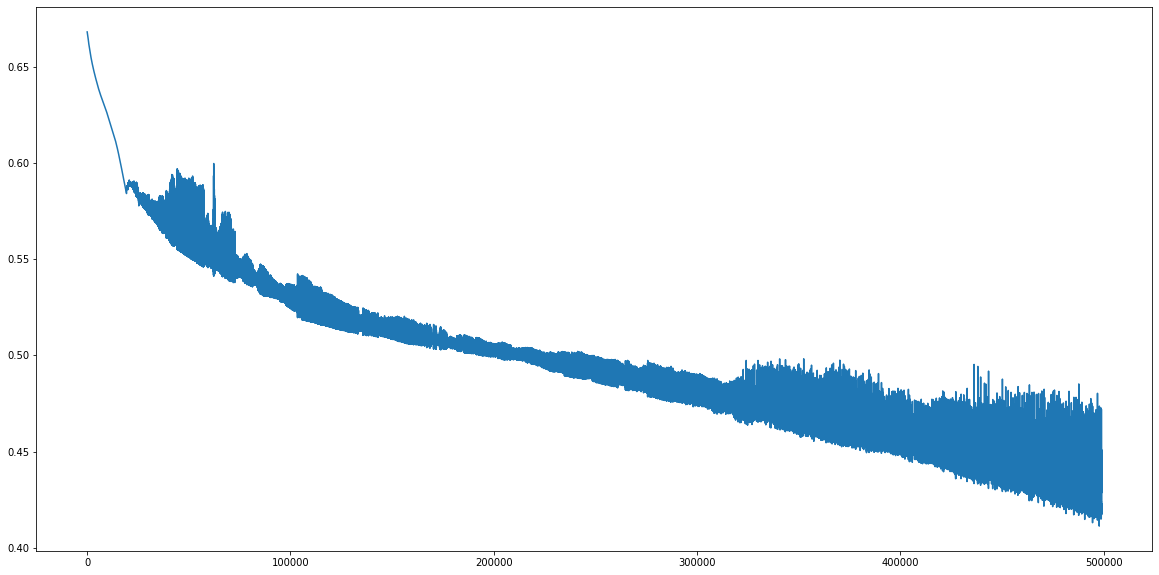

In [30]:
#graph the cost function
plt.figure(figsize = (20,10))
plt.plot(list[1000:])

We can save the model for later.

In [31]:
torch.save(model.state_dict(), 'Checkpoint/Logistic_Classification_Model_Eleven_64.cpkt')  #save model

We can predict y data using our final model applied to the training set of X data. If the predicted y value is less than 0.5, we store it in the numpy array train_y as 0, otherwise as 1. This way all of our predictions are either 0 or 1.

In [32]:
train_y = torch.sigmoid(model(X_data)).flatten().detach().numpy()
y_train = [0]*len(train_y)
for i in range(len(train_y)):
    if train_y[i] < 0.5:
        y_train[i] = 0
    else:
        y_train[i] = 1
train_y = np.array(y_train)
print(train_y)

[0 0 0 ... 1 0 1]


Similarly, we use our final model to predict y values using the test set of X, called X_test. 

If the predicted value of y is less than 0.5, we store it as 0 in the numpy array pred_y, if the predicted value of y is greater or equal to 0.5, we store it as 1 in the numpy array pred_y.

[1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1
 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1
 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 

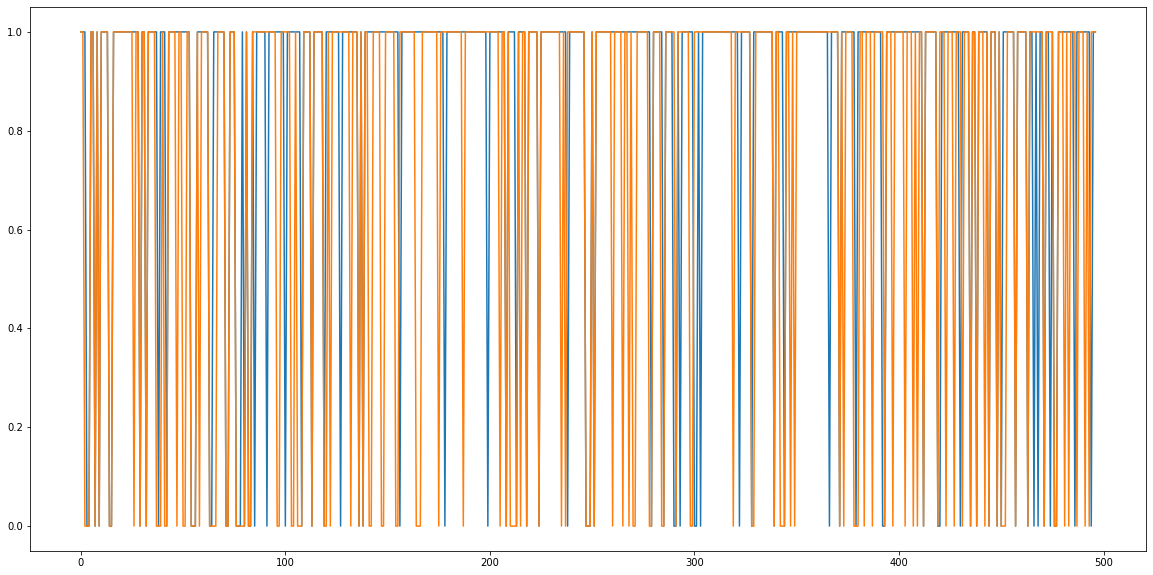

In [33]:
X_test = Variable(torch.Tensor(np.array(data.iloc[6000:,:11]).reshape(497,11)))
pred_y = torch.sigmoid(model(X_test)).flatten().detach().numpy()
y_pred = [0]*len(pred_y)
for i in range(len(pred_y)):
    if pred_y[i] < 0.5:
        y_pred[i] = 0
    else:
        y_pred[i] = 1
pred_y = np.array(y_pred)
print(pred_y)
plt.figure(figsize=(20,10))
plt.plot(pred_y)
plt.plot(np.array(data.iloc[6000:,11]))

We find the root mean squared error for both the training set and test set predictions.

In [34]:
print("train RMSE {}".format(np.sqrt(np.mean((train_y-np.array(data.iloc[:6000,11]))**2))))
print("test RMSE {}".format(np.sqrt(np.mean((pred_y-np.array(data.iloc[6000:,11]))**2))))


train RMSE 0.43950729990145404
test RMSE 0.44178164986443436


We find the confusion matrices for both the training set and the test set predictions.

In [35]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(np.array(data.iloc[:6000,11]), np.array(train_y)))
print(confusion_matrix(np.array(data.iloc[6000:,11]), pred_y))

[[1762  491]
 [ 668 3079]]
[[ 57  74]
 [ 23 343]]


And finally, we find the accuracy of both the training set and the test set predictions. Notice that the accuracy is much higher for a Six Layer Neural Network than for a One Layer Neural Network.

In [36]:
print('train accuracy {} %'.format(100 - np.mean(np.abs(train_y-np.array(data.iloc[:6000,11]))*100)))
print('test accuracy {} %'.format(100 - np.mean(np.abs(pred_y-np.array(data.iloc[6000:,11]))*100)))


train accuracy 80.68333333333334 %
test accuracy 80.48289738430583 %


The question arises if it is better to do more iterations with a smaller hidden size, or fewer iterations with a larger hidden size. The main constraint is the amount of time spent training the neural network. 

Here we use a Six Layer Neural Network, we decrease the hidden size to 54, but instead of doing 500000 iterations, we do 700000 iterations.

In [15]:
model = SixLayerNeuralNet(11, 54, 1)
criterion = nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
print(model)

SixLayerNeuralNet(
  (fc1): Linear(in_features=11, out_features=54, bias=True)
  (fc3): Linear(in_features=54, out_features=54, bias=True)
  (fc4): Linear(in_features=54, out_features=54, bias=True)
  (fc5): Linear(in_features=54, out_features=54, bias=True)
  (fc6): Linear(in_features=54, out_features=54, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=54, out_features=1, bias=True)
)


In [13]:
list = []
for epoch in range(700000):
    loss_epoch = 0
    predict_y = torch.sigmoid(model(X_data))
    loss = criterion(predict_y, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_epoch += loss.item()
    list.append(loss.item())
    if (epoch % 5000 == 0):
        print('epoch {}, cost function {}'.format(epoch, loss.item()))

epoch 0, cost function 0.7644971609115601
epoch 5000, cost function 0.6491987109184265
epoch 10000, cost function 0.6401117444038391
epoch 15000, cost function 0.6289299130439758
epoch 20000, cost function 0.6086214780807495
epoch 25000, cost function 0.6051837801933289
epoch 30000, cost function 0.5967406630516052
epoch 35000, cost function 0.590353786945343
epoch 40000, cost function 0.5844199657440186
epoch 45000, cost function 0.5791910290718079
epoch 50000, cost function 0.5739045739173889
epoch 55000, cost function 0.5694668889045715
epoch 60000, cost function 0.5655651092529297
epoch 65000, cost function 0.5603296756744385
epoch 70000, cost function 0.5558596849441528
epoch 75000, cost function 0.5510927438735962
epoch 80000, cost function 0.5464158654212952
epoch 85000, cost function 0.5445505976676941
epoch 90000, cost function 0.5401758551597595
epoch 95000, cost function 0.5331276655197144
epoch 100000, cost function 0.5325503945350647
epoch 105000, cost function 0.524160027

When we graph the cost function as a function of the number of iterations, we see that the convergence becomes slower after 550000 iterations.

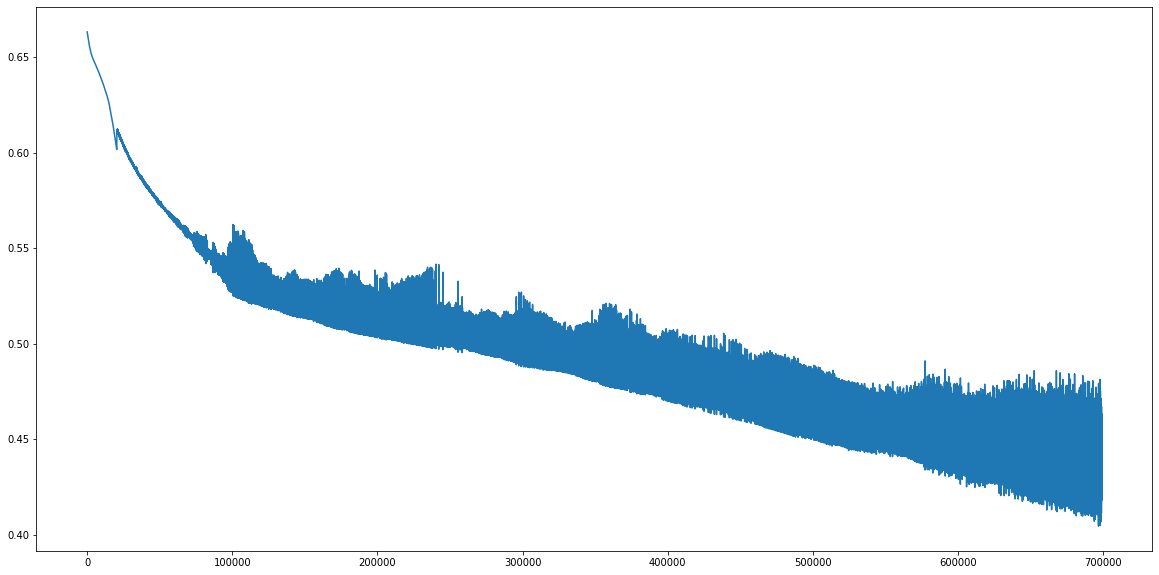

In [15]:
#graph the cost function
plt.figure(figsize = (20,10))
plt.plot(list[1000:])

We save the model.

In [16]:
torch.save(model.state_dict(), 'Checkpoint/Logistic_Classification_Model_Eleven_New.cpkt')  #save model

We predict the y values using the final model and the training set of X data. We assign y value to be 0 if the predicted value is less than 0.5 and assign y value to be 1 otherwise. We store the results in the numpy array train_y.

In [17]:
train_y = torch.sigmoid(model(X_data)).flatten().detach().numpy()
y_train = [0]*len(train_y)
for i in range(len(train_y)):
    if train_y[i] < 0.5:
        y_train[i] = 0
    else:
        y_train[i] = 1
train_y = np.array(y_train)
print(train_y)

[0 0 0 ... 0 0 0]


Now we predict the y values for the test set, using the final model and the test set of X data. We assign y value to be 0 if the predicted value is less than 0.5 and assign y value to be 1 otherwise. We store the results in the numpy array pred_y.

We graph both the test set of y and the predicted values of the test set of y.

[1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1
 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

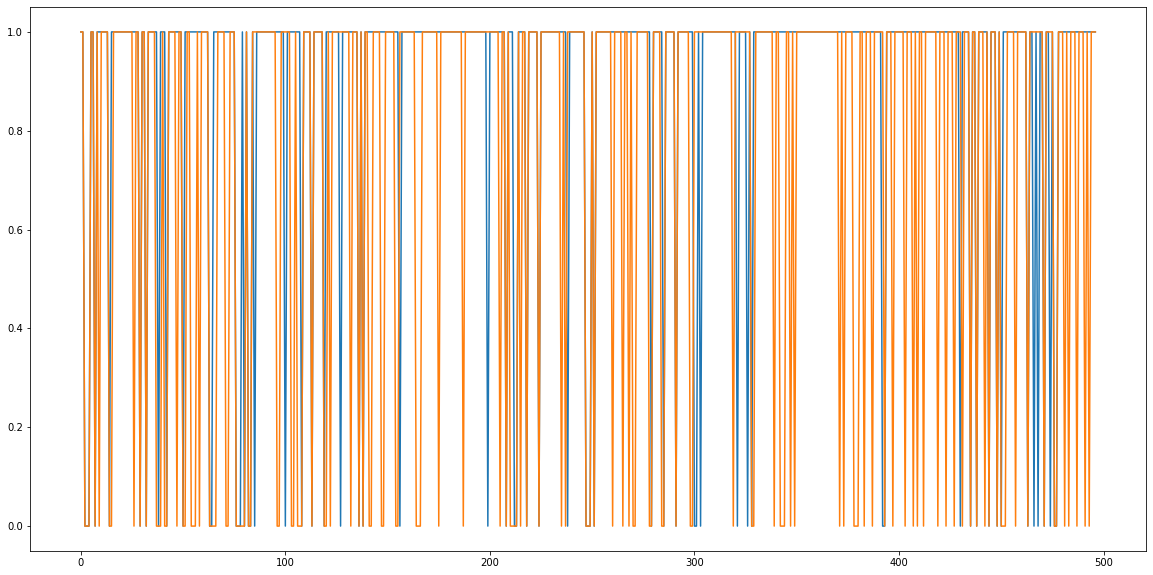

In [18]:
X_test = Variable(torch.Tensor(np.array(data.iloc[6000:,:11]).reshape(497,11)))
pred_y = torch.sigmoid(model(X_test)).flatten().detach().numpy()
y_pred = [0]*len(pred_y)
for i in range(len(pred_y)):
    if pred_y[i] < 0.5:
        y_pred[i] = 0
    else:
        y_pred[i] = 1
pred_y = np.array(y_pred)
print(pred_y)
plt.figure(figsize=(20,10))
plt.plot(pred_y)
plt.plot(np.array(data.iloc[6000:,11]))

We calculate the root mean square errors for the training set and the test set predictions.

In [19]:
print("train RMSE {}".format(np.sqrt(np.mean((train_y-np.array(data.iloc[:6000,11]))**2))))
print("test RMSE {}".format(np.sqrt(np.mean((pred_y-np.array(data.iloc[6000:,11]))**2))))


train RMSE 0.4522167621838005
test RMSE 0.45079853138111736


We calculate the confusion matrices for both the training set and the test set predictions.

In [20]:
print(confusion_matrix(np.array(data.iloc[:6000,11]), np.array(train_y)))
print(confusion_matrix(np.array(data.iloc[6000:,11]), pred_y))

[[1291  962]
 [ 265 3482]]
[[ 46  85]
 [ 16 350]]


Finally, we calculate the accuracy of the predictions for both the training data and the test data. 
Notice that there is 0.8% decrease of accuracy. Therefore increasing number of iterations is not as effective as increasing the size of hidden layers.

In [21]:
print('train accuracy {} %'.format(100 - np.mean(np.abs(train_y-np.array(data.iloc[:6000,11]))*100)))
print('test accuracy {} %'.format(100 - np.mean(np.abs(pred_y-np.array(data.iloc[6000:,11]))*100)))


train accuracy 79.55 %
test accuracy 79.67806841046277 %


Eight Layer Neural Network:

The question arises if it is better to construct a neural network with more layers, with a smaller (input/output) size of each layer, to achieve higher accuracy in the same amount of training time, than it is to construct a neural network with fewer layers, with a larger (input/output) size of each layer.

To that end, we construct an eight layer neural network with the input and output size of each hidden layer equal to 28.

In [16]:
class EightLayerNeuralNet(nn.Module):  #fully connected neural network with one hidden layer
    def __init__(self, num_features, hidden_size, num_classes):
        super(EightLayerNeuralNet, self).__init__()
        self.fc1 = nn.Linear(num_features, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, hidden_size)
        self.fc8 = nn.Linear(hidden_size, hidden_size)        
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = self.relu(out)
        out = self.fc6(out)
        out = self.relu(out)
        out = self.fc7(out)
        out = self.relu(out)
        out = self.fc8(out)
        out = self.relu(out)    
        out = self.fc2(out)
        return out 

The first layer has input dimension eleven, because input data, X, has eleven columns and the output dimension 28. The last layer has the input dimension 28 and the output dimension one, because the output data, y, has one column. For simplicity, all hidden layers have an input dimension 28 and an output dimension 28. We take the learning rate slightly higher at 0.02, to speed up convergence.

In [17]:
model = EightLayerNeuralNet(11, 28, 1)
criterion = nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.002)

print(model)

EightLayerNeuralNet(
  (fc1): Linear(in_features=11, out_features=28, bias=True)
  (fc3): Linear(in_features=28, out_features=28, bias=True)
  (fc4): Linear(in_features=28, out_features=28, bias=True)
  (fc5): Linear(in_features=28, out_features=28, bias=True)
  (fc6): Linear(in_features=28, out_features=28, bias=True)
  (fc7): Linear(in_features=28, out_features=28, bias=True)
  (fc8): Linear(in_features=28, out_features=28, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=28, out_features=1, bias=True)
)


We run our eight layer neural network through 500000 iterations.

In [39]:
list = []
for epoch in range(500000):
    loss_epoch = 0
    predict_y = torch.sigmoid(model(X_data))
    loss = criterion(predict_y, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_epoch += loss.item()
    list.append(loss.item())
    if (epoch % 5000 == 0):
        print('epoch {}, cost function {}'.format(epoch, loss.item()))

epoch 0, cost function 0.6883738040924072
epoch 5000, cost function 0.6620518565177917
epoch 10000, cost function 0.6571301221847534
epoch 15000, cost function 0.6503840684890747
epoch 20000, cost function 0.6404992938041687
epoch 25000, cost function 0.6035770773887634
epoch 30000, cost function 0.587110161781311
epoch 35000, cost function 0.5755278468132019
epoch 40000, cost function 0.5666053295135498
epoch 45000, cost function 0.5586438775062561
epoch 50000, cost function 0.5524645447731018
epoch 55000, cost function 0.5465132594108582
epoch 60000, cost function 0.5425238609313965
epoch 65000, cost function 0.535707414150238
epoch 70000, cost function 0.5325800776481628
epoch 75000, cost function 0.529958188533783
epoch 80000, cost function 0.5320378541946411
epoch 85000, cost function 0.5242437124252319
epoch 90000, cost function 0.5258981585502625
epoch 95000, cost function 0.5237104892730713
epoch 100000, cost function 0.520756185054779
epoch 105000, cost function 0.514702737331

We graph the cost function as a function of the number of iterations. Notice that the convergence becomes very slow (possibly non-existent) after 330000 iterations.

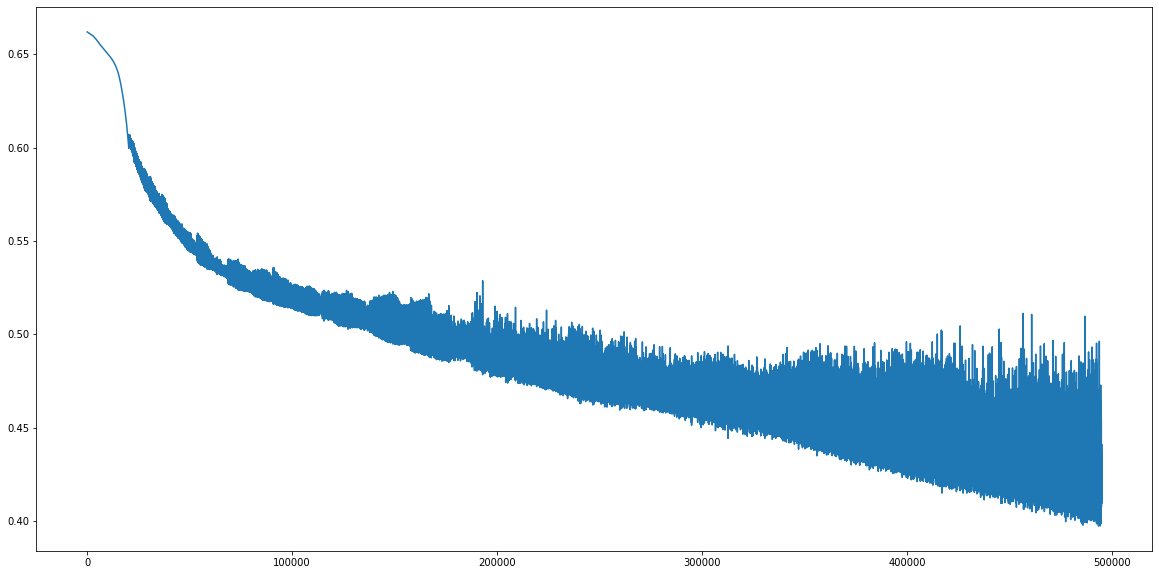

In [40]:
#graph the cost function
plt.figure(figsize = (20,10))
plt.plot(list[5000:])

In [41]:
torch.save(model.state_dict(), 'Checkpoint/Logistic_Classification_Model_Fifteen.cpkt')  #save model

We predict the training data y using the final model and the set of training data X. We say that y is 0, if the predicted value is less than 0.5 and that y is 1 otherwise. We store the predictions in the numpy array train_y.

In [42]:
train_y = torch.sigmoid(model(X_data)).flatten().detach().numpy()
y_train = [0]*len(train_y)
for i in range(len(train_y)):
    if train_y[i] < 0.5:
        y_train[i] = 0
    else:
        y_train[i] = 1
train_y = np.array(y_train)
print(train_y)

[0 0 0 ... 0 0 0]


We predict the test data y using the final model and the set of test data X. We say that y is 0, if the predicted value is less than 0.5 and that y is 1 otherwise. We store the predictions in the numpy array pred_y.

We graph both the test set of y and the predicted values of the test sey of y.

[1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1
 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1
 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1
 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1
 0 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 

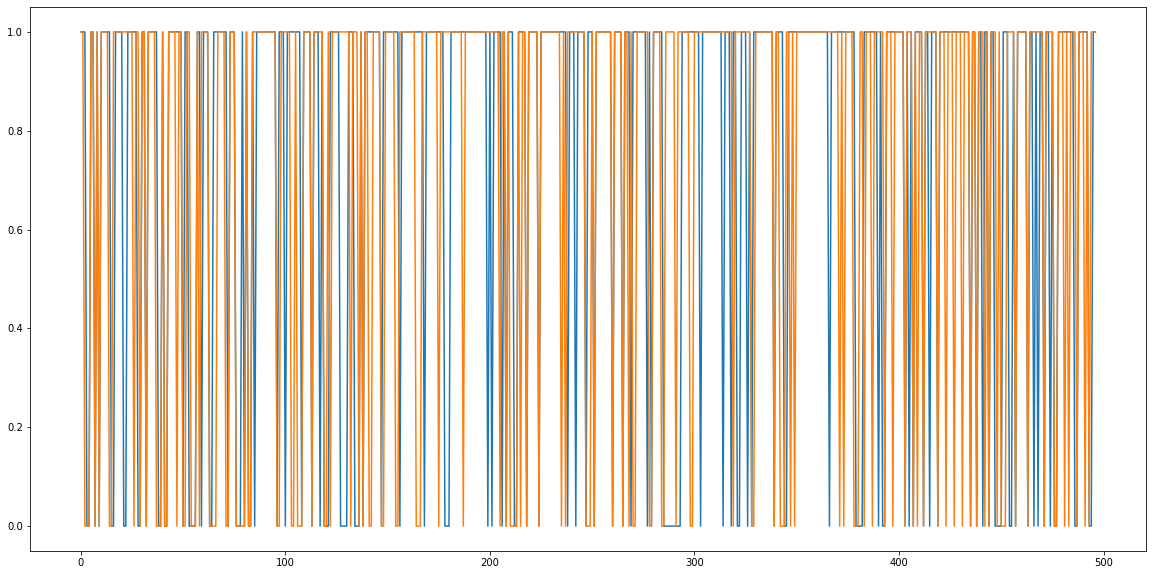

In [43]:
X_test = Variable(torch.Tensor(np.array(data.iloc[6000:,:11]).reshape(497,11)))
pred_y = torch.sigmoid(model(X_test))
y_pred = [0]*len(pred_y)
for i in range(len(pred_y)):
    if pred_y[i] < 0.5:
        y_pred[i] = 0
    else:
        y_pred[i] = 1
pred_y = np.array(y_pred)
print(pred_y)

plt.figure(figsize=(20,10))
plt.plot(pred_y)
plt.plot(np.array(data.iloc[6000:,11]))

We calculate the root mean squared error for both the training set and the test set predictions.

In [44]:
print("train RMSE {}".format(np.sqrt(np.mean((train_y-np.array(data.iloc[:6000,11]))**2))))
print("test RMSE {}".format(np.sqrt(np.mean((pred_y-np.array(data.iloc[6000:,11]))**2))))

train RMSE 0.44962947708826506
test RMSE 0.49949672860925537


We calculate the confusion matrices for both the training predictions and the test predictions.

In [45]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(np.array(data.iloc[:6000,11]), np.array(train_y)))
print(confusion_matrix(np.array(data.iloc[6000:,11]), pred_y))

[[1836  417]
 [ 796 2951]]
[[ 66  65]
 [ 59 307]]


Last, we calculate the accuracy of the predictions of both the training data and the test data.

In [46]:
print('train accuracy {} %'.format(100 - np.mean(np.abs(train_y-np.array(data.iloc[:6000,11]))*100)))
print('test accuracy {} %'.format(100 - np.mean(np.abs(pred_y-np.array(data.iloc[6000:,11]))*100)))


train accuracy 79.78333333333333 %
test accuracy 75.0503018108652 %


Notice that the accuracy of the prediction on the test data is almost 5% lower than on the training data. This (and the slow convergence of the loss function) suggests that the data was overfitted. It is possible, since the size of the hidden layers is almost 50% less than in the previous model.

To combat overfitting, we run the same model through fewer iterations. We stop after 330000 iterations instead of 500000 iterations.

In [12]:
list = []
for epoch in range(330000):
    loss_epoch = 0
    predict_y = torch.sigmoid(model(X_data))
    loss = criterion(predict_y, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_epoch += loss.item()
    list.append(loss.item())
    if (epoch % 5000 == 0):
        print('epoch {}, cost function {}'.format(epoch, loss.item()))

epoch 0, cost function 0.6895760297775269
epoch 5000, cost function 0.6590498685836792
epoch 10000, cost function 0.6515230536460876
epoch 15000, cost function 0.6450616717338562
epoch 20000, cost function 0.6318401098251343
epoch 25000, cost function 0.6086122393608093
epoch 30000, cost function 0.5953896641731262
epoch 35000, cost function 0.5844599604606628
epoch 40000, cost function 0.5754233598709106
epoch 45000, cost function 0.5691534280776978
epoch 50000, cost function 0.5620225667953491
epoch 55000, cost function 0.5556373000144958
epoch 60000, cost function 0.5514469146728516
epoch 65000, cost function 0.545418918132782
epoch 70000, cost function 0.5398038029670715
epoch 75000, cost function 0.5364788174629211
epoch 80000, cost function 0.5308796167373657
epoch 85000, cost function 0.5310440063476562
epoch 90000, cost function 0.5265034437179565
epoch 95000, cost function 0.5250706672668457
epoch 100000, cost function 0.5182507038116455
epoch 105000, cost function 0.518453478

This is the graph of the cost function as a function of the number of iterations. Notice that the convergence is better.

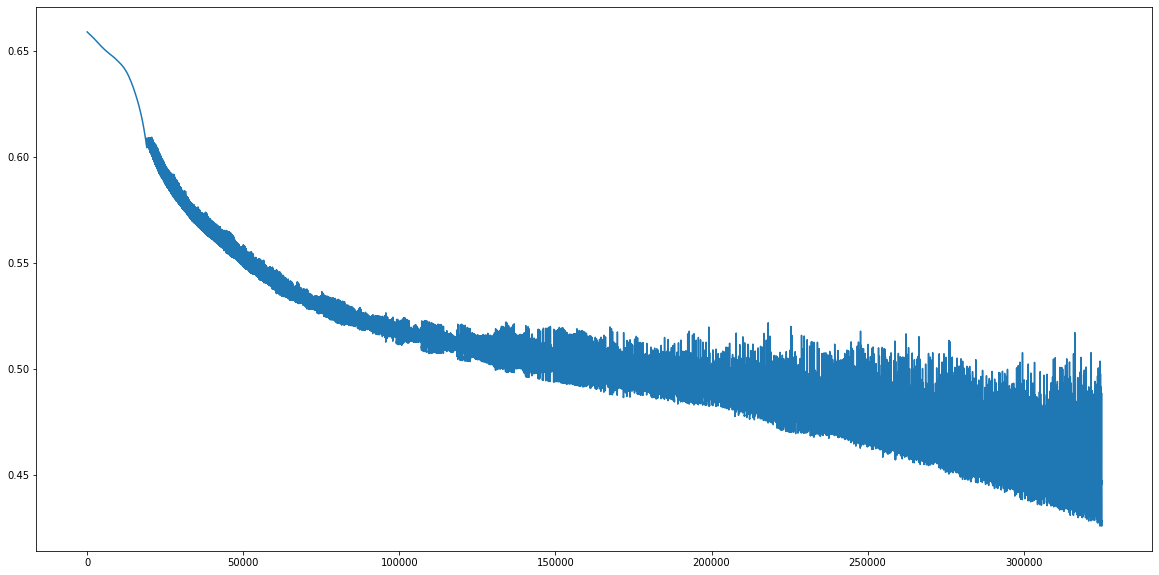

In [13]:
#graph the cost function
plt.figure(figsize = (20,10))
plt.plot(list[5000:])

We predict the training data y using the final model and the set of training data X. We say that y is 0, if the predicted value is less than 0.5 and that y is 1 otherwise. We store the predictions in the numpy array train_y.

In [14]:
train_y = torch.sigmoid(model(X_data)).flatten().detach().numpy()
y_train = [0]*len(train_y)
for i in range(len(train_y)):
    if train_y[i] < 0.5:
        y_train[i] = 0
    else:
        y_train[i] = 1
train_y = np.array(y_train)
print(train_y)

[0 0 0 ... 0 0 0]


We predict the test data y using the final model and the set of test data X. We say that y is 0, if the predicted value is less than 0.5 and that y is 1 otherwise. We store the predictions in the numpy array pred_y.

We graph both the actual test values of y and the predicted test values of y.

[1 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1
 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1
 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1
 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 

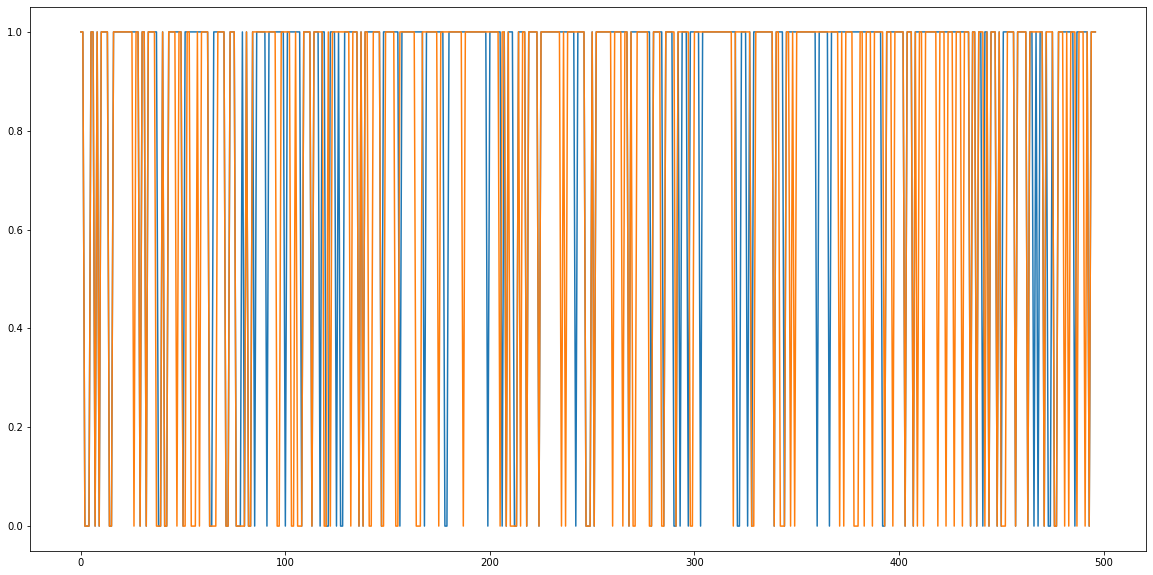

In [15]:
X_test = Variable(torch.Tensor(np.array(data.iloc[6000:,:11]).reshape(497,11)))
pred_y = torch.sigmoid(model(X_test))
y_pred = [0]*len(pred_y)
for i in range(len(pred_y)):
    if pred_y[i] < 0.5:
        y_pred[i] = 0
    else:
        y_pred[i] = 1
pred_y = np.array(y_pred)
print(pred_y)

plt.figure(figsize=(20,10))
plt.plot(pred_y)
plt.plot(np.array(data.iloc[6000:,11]))

We calculate the root mean squared error of predictions for both the training set and the test set.

In [16]:
print("train RMSE {}".format(np.sqrt(np.mean((train_y-np.array(data.iloc[:6000,11]))**2))))
print("test RMSE {}".format(np.sqrt(np.mean((pred_y-np.array(data.iloc[6000:,11]))**2))))

train RMSE 0.4525851669391445
test RMSE 0.4530247105070317


We print out the confusion matrices for both the test data and the training data predictions. 
For comparison, here are the confusion matrices for the Six Layer Neural Network with hidden_size = 54.

Training set confusion matrix:

[[1836  417]

 [ 796 2951]]
 
Test set confusion matrix:
 
[[ 66  65]

 [ 59 307]]

In [17]:
print(confusion_matrix(np.array(data.iloc[:6000,11]), np.array(train_y)))
print(confusion_matrix(np.array(data.iloc[6000:,11]), pred_y))

[[1659  594]
 [ 635 3112]]
[[ 60  71]
 [ 31 335]]


From comparing the confusion matrices, we can see that the Eight Layer Neural Network is better at predicting 0s and is almost as good at predicting 1s as a Six Layer Neural Network.

Finally, here is the accuracy of the training set prediction and the test set prediction. Notice that it is only 0.5% lower than the accuracy of the Six Layer Neural Network with hidden_size = 54.

In [18]:
print('train accuracy {} %'.format(100 - np.mean(np.abs(train_y-np.array(data.iloc[:6000,11]))*100)))
print('test accuracy {} %'.format(100 - np.mean(np.abs(pred_y-np.array(data.iloc[6000:,11]))*100)))


train accuracy 79.51666666666667 %
test accuracy 79.47686116700201 %


Conclusion: an Eight Layer Neural Network with hidden_size = 28 is almost as accurate at predicting the test data as a Six Layer Neural Network with hidden_size = 54 and is much faster. However, due to the smaller hidden_size of the Eight Layer Neural Network, the overfitting becomes a real problem, so for example one cannot use a larger number of iterations to increase the accuracy of the prediction. However a larger number of iterations in order to increase the accuracy of the prediction can be used for the Six Layer Neural Network due to a larger hidden_size.